In [36]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
data = pd.read_parquet('cleaned.parquet')



In [38]:
# Force-fill missing insider values where returns are available
for col in ['insider_score_net', 'insider_score_log_ratio']:
    # Only fill for rows where ret_f1 is not null
    data.loc[data['ret_f1'].notna() & data[col].isna(), col] = 0


In [39]:
non_factor_cols = {'permno', 'yyyymm', 'monthid', 'ticker', 'conm', 'gvkey', 'cusip', 'naics', 'gsubind', 'PRC', 'RET', 'SHROUT', 'ret_f1', 'ret_f2', 'ret_f3', 'ret_f4', 'ret_f5', 'ret_f6', 'ret_f7', 'ret_f8', 'ret_f9', 'ret_f10', 'ret_f11', 'ret_f12', 'date_x', 'fdate', 'ret', 'date_y', 'date'}
factor_cols = set(data.columns) - non_factor_cols

In [40]:
print("✅ Columns present:", "insider_score_net" in data.columns and "insider_score_log_ratio" in data.columns)

# Are there any non-null values?
print("✅ insider_score_net notna:", data['insider_score_net'].notna().sum())
print("✅ insider_score_log_ratio notna:", data['insider_score_log_ratio'].notna().sum())

# Do they vary within months?
print("✅ Unique scores in 201812:", data[data['yyyymm'] == 201812]['insider_score_net'].nunique())

✅ Columns present: True
✅ insider_score_net notna: 81600
✅ insider_score_log_ratio notna: 81600
✅ Unique scores in 201812: 4


In [41]:
def calculate_univariate_power(data, factor_cols):
    results = {
        'factor': [],
        'avg_coef': [],
        't_stat': [],
        'p_value': []
    }
    months = sorted(data['yyyymm'].unique())
    
    # For each factor, run monthly cross-sectional regressions
    for factor in factor_cols:
        coefs = []
        
        for month in months:
            month_data = data[data['yyyymm'] == month].copy()
            
            if len(month_data) < 10: # At least 10 data points before proceeding
                   continue
            
            X = month_data[[factor]].copy()
            X = sm.add_constant(X)
            y = month_data['ret_f1'] # Predicting *next* month's returns
            if X.isnull().values.any() or y.isnull().values.any():
                   continue
            
            model = sm.OLS(y, X).fit()
            if len(model.params) < 2:
                   continue
            coefs.append(model.params.iloc[1])  # Index 1 is the factor coefficient (0 is intercept)
        
        if len(coefs) > 0:
            avg_coef = np.mean(coefs)
            std_coefs = np.std(coefs)
    
            if std_coefs > 0:
                t_stat = (avg_coef / std_coefs) * np.sqrt(len(coefs))
                p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=len(coefs)-1))
            else:
                # Handle the case where all coefficients are identical
                if avg_coef != 0:
                    # If all coefficients are non-zero and identical, this is strong evidence
                    t_stat = np.inf if avg_coef > 0 else -np.inf
                    p_value = 0.0
                else:
                    # If all coefficients are zero, no effect
                    t_stat = 0.0
                    p_value = 1.0
			
            results['factor'].append(factor)
            results['avg_coef'].append(avg_coef)
            results['t_stat'].append(t_stat)
            results['p_value'].append(p_value)
    
    results_df = pd.DataFrame(results)
    results_df['abs_t_stat'] = results_df['t_stat'].abs()
    results_df = results_df.sort_values('abs_t_stat', ascending=False)
    
    return results_df

In [42]:
factor_power = calculate_univariate_power(data, factor_cols)

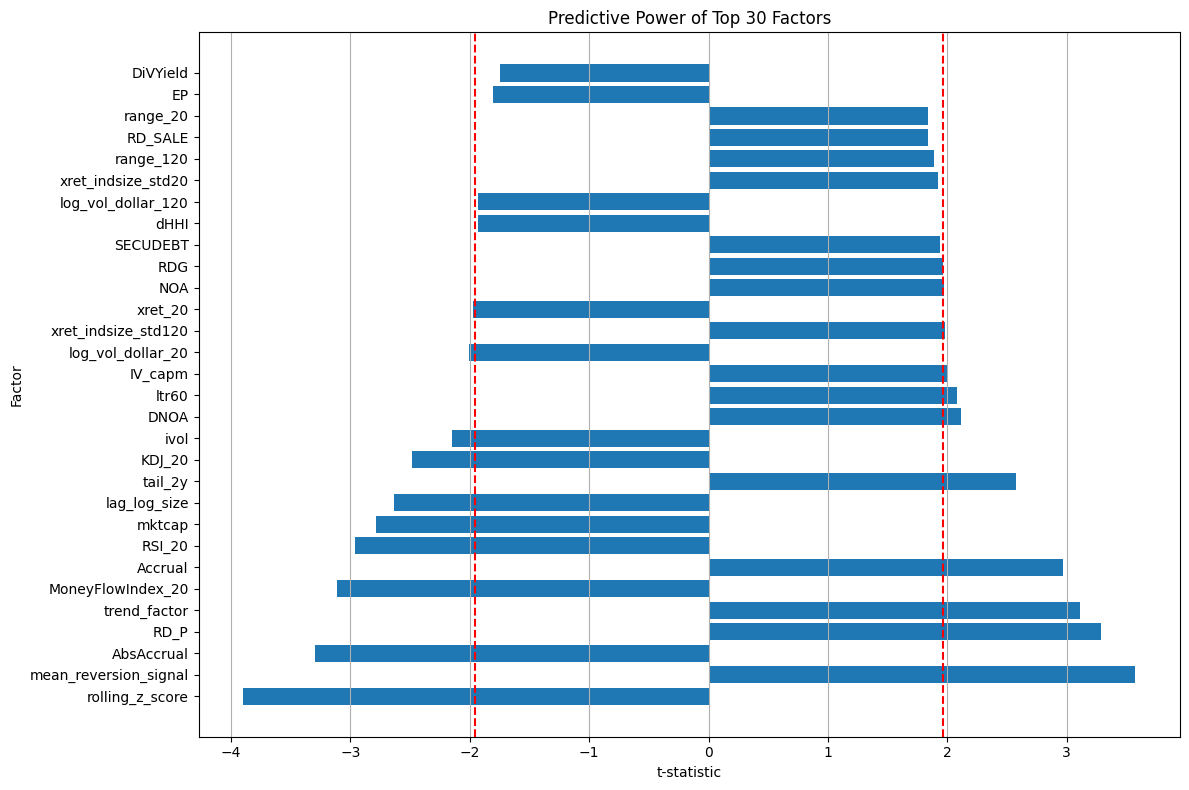

In [43]:
# Plot t-statistics of top 30 factors
top_factors = factor_power.head(30)

plt.figure(figsize=(12, 8))
plt.barh(top_factors['factor'], top_factors['t_stat'])
plt.axvline(x=1.96, color='r', linestyle='--', label='95% significance')
plt.axvline(x=-1.96, color='r', linestyle='--')
plt.title('Predictive Power of Top 30 Factors')
plt.xlabel('t-statistic')
plt.ylabel('Factor')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [45]:
factor_power.to_excel('factor_power.xlsx')

## WIP: Correlation Analysis

Motivation: So we don't choose several highly correlated factors for our final strategy...

In [46]:
def analyze_factor_correlations(data, top_factors):
    factor_data = data[top_factors]
    
    corr_matrix = factor_data.corr()
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                linewidths=0.5, fmt=".2f")
    plt.title('Correlation Matrix of Top Factors')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def identify_correlated_pairs(corr_matrix, threshold=0.7):
    correlated_pairs = []
    
    # Upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    for col in upper.columns:
        for idx in upper.index:
            if abs(upper.loc[idx, col]) > threshold:
                correlated_pairs.append({
                    'factor1': idx,
                    'factor2': col,
                    'correlation': upper.loc[idx, col]
                })
    
    return pd.DataFrame(correlated_pairs).sort_values('correlation', key=abs, ascending=False)